In [113]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from matplotlib import cm
from matplotlib import gridspec
import copy
from autograd import grad # autodiff for gradient computation
from PIL import Image
from scipy.signal import find_peaks

### Problem 1
Find min of g(w) where w is N-dim vector with range [0,1]

Use global opt based on 1) regular, or 2) random grid search

=> P points are constructed for each component of W

[ 6.93147181 13.86294361 20.79441542 27.72588722 34.65735903 41.58883083
        -inf        -inf        -inf]


/var/folders/_8/nks3d0kn12j1p9b5_zyc49k40000gn/T/ipykernel_83553/3958706477.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(np.array(P)**np.array(N))
/var/folders/_8/nks3d0kn12j1p9b5_zyc49k40000gn/T/ipykernel_83553/3958706477.py:7: RuntimeWarning: invalid value encountered in log
  return np.log(np.array(P)**np.array(N))


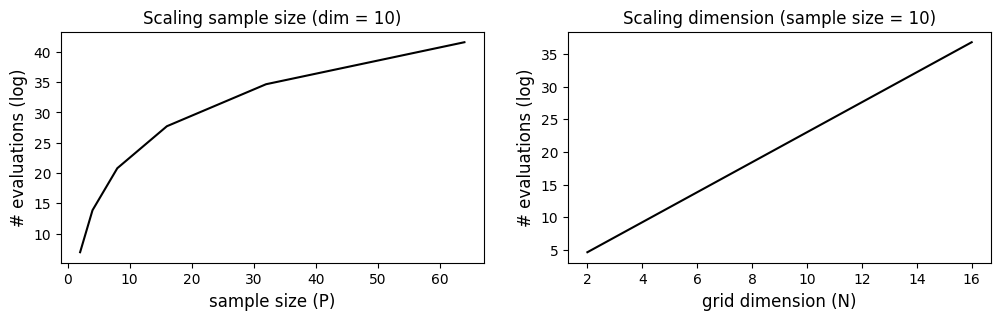

In [114]:
# Q1) expression for tot. # points (M) to eval g(w); M = f(N, P)
def get_M(N, P):
    '''
    N: grid dimension
    P: sample batch size per dimension
    '''
    return np.log(np.array(P)**np.array(N))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot M vs. P for P = [2, 4, 8, 16, 32, ...] and N = 10
P = [2**x for x in range(1, 10)]
N = [10] * len(P)
M = get_M(N, P)
print(M)
ax1.plot(P, M, 'k')
ax1.set_xlabel('sample size (P)', fontsize=12)
ax1.set_ylabel('# evaluations (log)', fontsize=12)
ax1.set_title('Scaling sample size (dim = 10)')

# Plot M vs. N for N = [2, 4, 8, 16, 32, ...] and P = 10
N = [2**x for x in range(1, 10)]
P = [10] * len(P)
M = get_M(N, P)
ax2.plot(N, M, 'k')
ax2.set_xlabel('grid dimension (N)', fontsize=12)
ax2.set_ylabel('# evaluations (log)', fontsize=12)
ax2.set_title('Scaling dimension (sample size = 10)')

plt.show()

### Q2) Compute cost of coordinate search (CS) vs. coordinate descent (CD)

constrains...
- S evaluations of g(w) are allowed

which approach does more potential updates to w?
- ratio = n_updates_w_higher / n_updates_w_lower

NOTE: step != potential update to w. step happens iff potential update reduces g(w)

/var/folders/_8/nks3d0kn12j1p9b5_zyc49k40000gn/T/ipykernel_83553/755542471.py:18: RuntimeWarning: divide by zero encountered in divide
  ratio = cd / cs


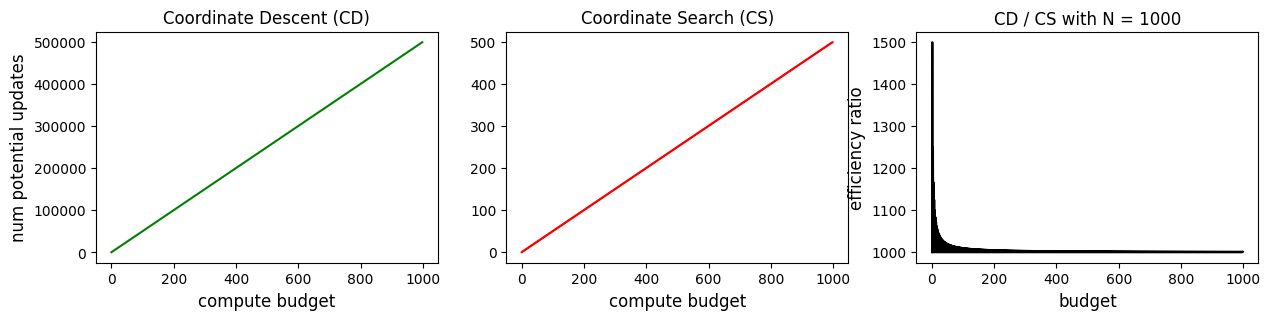

In [115]:
# CS: every 2N eval of g(w) => 1 update ==> /2N
# CD: every 2 eval of g(w) => N updates ==> /2
# ratio = N

def n_potential_updates(S, N, mode):
    if mode == 'CS':
        return S // (2*N)
    elif mode == 'CD':
        return S // 2

# plot ratio vs. S
# S = [N, 2N, ...]
N = 1000
S = np.arange(1, 1000) * N # multiples of N

cs = n_potential_updates(S, N, 'CS')
cd = n_potential_updates(S, N, 'CD')
ratio = cd / cs


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
# growth curves for cd and cs
ax1.plot(cd, 'g')
ax1.set_xlabel('compute budget', fontsize=12)
ax1.set_ylabel('num potential updates', fontsize=12)
ax1.set_title('Coordinate Descent (CD)')

ax2.plot(cs, 'r')
ax2.set_xlabel('compute budget', fontsize=12)
ax2.set_title('Coordinate Search (CS)')

# Plot ratios
ax3.plot(ratio, 'k')
ax3.set_xlabel('budget', fontsize=12)
ax3.set_ylabel('efficiency ratio', fontsize=12)
ax3.set_title('CD / CS with N = {}'.format(N))

plt.show()

Q2.1) Minimizing a quadratic function and the curse of dimensionality 

g(w) = w.t()*w

In [138]:
def random_eval_experiment(mode):
    '''
    Experiment illutrating how quickly global random evaluation will fail as a method of optimization.  Output is minimum value attained by random sampling over the cube [-1,1] x [-1,1] x... [-1,1] evaluating simple quadratic for 100, 1000, or 10000 times.  The dimension is increased from 1 to 100 and the minimum plotted for each dimension.
    '''    
    g = lambda w: np.dot(w.T,w)
    mean_evals = []
    big_dim = 100
    n_pts = 10000
    milestones = [100,1000,10000]
    # milestones = [100]

    for dim in range(big_dim):
        dim_eval = []
        m_eval = []
        for pt in range(n_pts):  
            if mode == 'random':           
                direction = np.random.randn(dim + 1,1)
            elif mode == 'uniform':
                direction = np.random.uniform(-1, 1, dim + 1)
            
            err = g(direction)
            dim_eval.append(err)
            if (pt+1) in milestones:
                m_eval.append(np.min(dim_eval))
        
        mean_evals.append(m_eval)


    mean_evals_global = np.asarray(mean_evals)
    fig = plt.figure(figsize = (6,3))
    gs = gridspec.GridSpec(1, 1, width_ratios=[1]) 
    fig.subplots_adjust(wspace=0.5,hspace=0.01)

    ax = plt.subplot(gs[0])
    for k in range(len(milestones)):
        mean_evals = mean_evals_global[:,k]
        ax.plot(np.arange(big_dim)+1,mean_evals)
        ax.set_xlabel('dimension of input')
        ax.set_ylabel('funciton value')

    t = [str(p) for p in milestones]
    ax.legend(t, bbox_to_anchor=(1, 0.5))
    ax.plot(np.arange(big_dim) + 1,np.arange(big_dim)*0,linewidth=1,linestyle='--',color = 'k')
    plt.show()

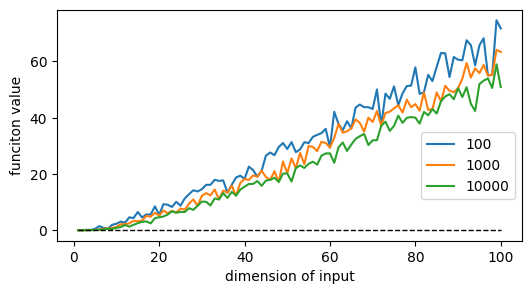

In [139]:
random_eval_experiment('random')

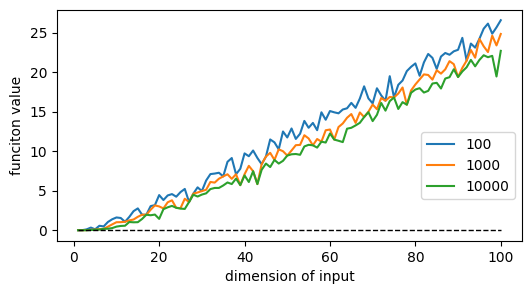

In [140]:
random_eval_experiment('uniform')

### Q 2.3 Using Random search to minimize a nonconvex function

In [119]:
def random_search(g, alpha_choice, max_its, w, num_samples):
    # run random search
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1, max_its + 1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1 / k
        else:
            alpha = alpha_choice
            
        # record weights and cost evaluation
        weight_history.append(w)
        cost_history.append(g(w))
        
        # construct set of random unit directions
        directions = np.random.randn(num_samples, np.size(w))
        # norms = np.sqrt(np.sum(directions * directions, axis = 1))[:, np.newaxis]
        norms = np.linalg.norm(directions, axis = 1)[:, np.newaxis]
        directions = directions / norms   
        
        ### pick best descent direction
        # compute all new candidate points
        w_candidates = w + alpha * directions
        
        # evaluate all candidates
        evals = np.array([g(w_val) for w_val in w_candidates])

        # if we find a real descent direction take the step in its direction
        ind = np.argmin(evals)
        if g(w_candidates[ind]) < g(w):
            # pluck out best descent direction
            d = directions[ind,:]
        
            # take step
            w = w + alpha * d
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

def plot_contours(g, weight_history, view, flag3D, title):
    weights_steps_x = np.array([i[0] for i in weight_history])
    weights_steps_y = np.array([i[1] for i in weight_history])
    x = y = np.arange(-4.5, 4.5, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([g(np.array([x,y])) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)
    if (flag3D):
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_subplot(111,projection='3d')
        ax.quiver(weights_steps_x[:-1], weights_steps_y[:-1], np.zeros(weights_steps_x[:-1].shape[0]), weights_steps_x[1:]-weights_steps_x[:-1], weights_steps_y[1:]-weights_steps_y[:-1], np.zeros(weights_steps_x[:-1].shape[0]),\
            color='k')
        ax.grid(False)
        ax.plot_surface(X, Y, Z, alpha=0.8, cmap=cm.coolwarm, linewidth=10, antialiased=False)
        ax.view_init(view[0], view[1])
        ax.set_xlabel(r'$w_1$')
        ax.set_ylabel(r'$w_2$')
        ax.set_zlabel(r'$g(w)$')
        ax.set_title(title,fontsize=16)
    fig = plt.figure(figsize=(5,5))
    cp = plt.contourf(X, Y, Z, cmap='coolwarm')
    plt.colorbar(cp)
    plt.xlabel(r'$w_1$', fontsize=12)
    plt.ylabel(r'$w_2$', fontsize=12)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.plot(weights_steps_x, weights_steps_y, 'sk', markersize=4)
    plt.quiver(weights_steps_x[:-1], weights_steps_y[:-1], weights_steps_x[1:]-weights_steps_x[:-1], weights_steps_y[1:]-weights_steps_y[:-1], scale_units='xy', angles='xy', scale=1)
    plt.plot(weights_steps_x[-1], weights_steps_y[-1], 'sy')
    plt.title(title,fontsize=16)
    plt.show()

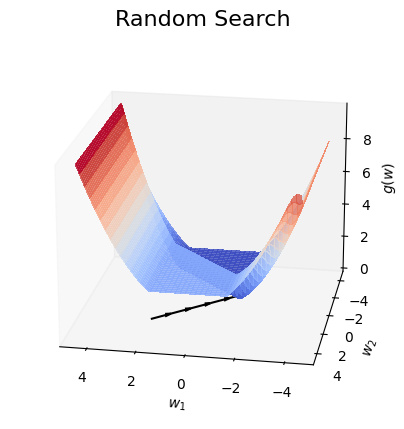

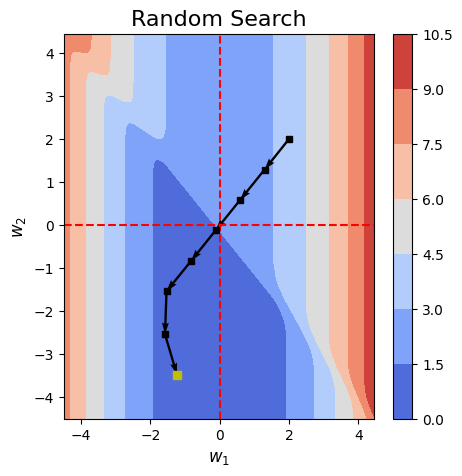

In [120]:
g = lambda w: np.tanh(4*w[0] + 4*w[1]) + max(0.4*w[0]**2,1) + 1

alpha_choice = 1; w = np.array([2,2]); num_samples = 1000; max_its = 8
weight_history, cost_history = random_search(g, alpha_choice, max_its ,w, num_samples)

plot_contours(g, weight_history, view=[20,100], flag3D=True, title = 'Random Search')

### Q 2.9) Coordinate search with diminishing steplength

In [121]:
# zero order coordinate search
def coordinate_search(g,alpha_choice,max_its,w):
    # construct set of all coordinate directions
    #directions_plus = np.eye(np.size(w),np.size(w))
    directions_plus = np.eye(np.size(w))
    #directions_minus = - np.eye(np.size(w),np.size(w))
    directions_minus = - np.eye(np.size(w))
    directions = np.concatenate((directions_plus,directions_minus),axis=0)
        
    # run coordinate search
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
            
        # record weights and cost evaluation
        weight_history.append(w)
        cost_history.append(g(w))
        
        ### pick best descent direction
        # compute all new candidate points
        w_candidates = w + alpha*directions
        
        # evaluate all candidates
        evals = np.array([g(w_val) for w_val in w_candidates])

        # if we find a real descent direction take the step in its direction
        ind = np.argmin(evals)
        if g(w_candidates[ind]) < g(w):
            # pluck out best descent direction
            d = directions[ind,:]
        
            # take step
            w = w + alpha*d
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

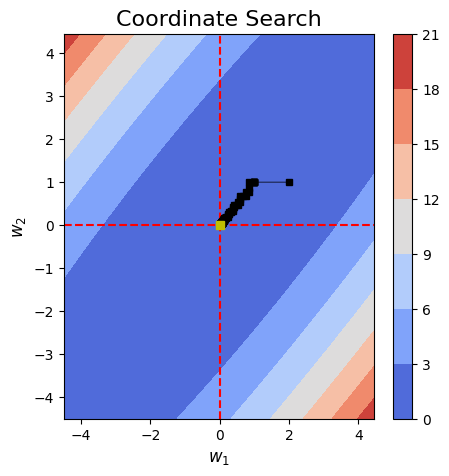

Coordinate search found the minimum with error 0.008!


In [122]:
g = lambda w: 0.26*(w[0]**2 + w[1]**2) - 0.48*w[0]*w[1]

alpha_choice = 'diminishing'; w = np.array([2,1]); max_its = 1000
weight_hist, cost_hist = coordinate_search(g,alpha_choice,max_its,w)

plot_contours(g, weight_hist, view=[20,100], flag3D=False, title = 'Coordinate Search')

err = np.linalg.norm(weight_hist[-1] - np.array([0,0]))
if err < 1e-2:
    print(f'Coordinate search found the minimum with error {err:.3f}!')
else:
    print(f'Coordinate search did not find the minimum with error {err:3.f}!')

### Q 2.10) Coordinate search versus coordinate descent

In [123]:
def coordinate_descent_zero_order(g,alpha_choice,max_its,w):  
    # run coordinate search
    N = np.size(w)
    weight_history = []         # container for weight history
    cost_history = []           # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):        
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # random shuffle of coordinates
        c = np.random.permutation(N)
        
        # forming the direction matrix out of the loop
        cost = g(w)
        
        # loop over each coordinate direction
        for n in range(N):
            direction = np.zeros((N,1)).flatten()
            direction[c[n]] = 1
    
            # record weights and cost evaluation
            weight_history.append(w)
            cost_history.append(cost)

            # evaluate all candidates
            evals =  [g(w + alpha*direction)]
            evals.append(g(w - alpha*direction))
            evals = np.array(evals)

            # if we find a real descent direction take the step in its direction
            ind = np.argmin(evals)
            if evals[ind] < cost_history[-1]:
                # take step
                w = w + ((-1)**(ind))*alpha*direction
                cost = evals[ind]
        
    # record weights and cost evaluation
    weight_history.append(w)
    cost_history.append(g(w))
    return weight_history,cost_history

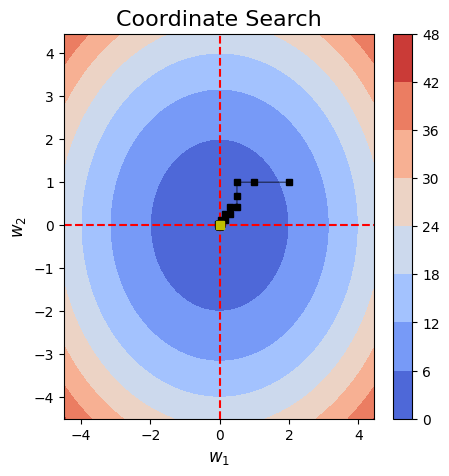

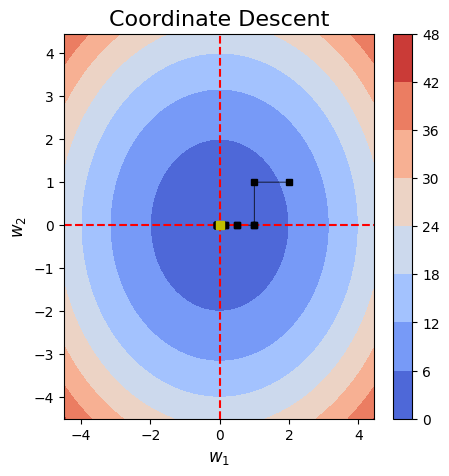

In [124]:
g = lambda w: np.dot(w.T,w) + 2

alpha_choice = 'diminishing'; w = np.array([2,1]); max_its = 1000
weight_hist, cost_hist = coordinate_search(g,alpha_choice,max_its,w)

plot_contours(g, weight_hist, view=[20,100], flag3D=False, title = 'Coordinate Search')

alpha_choice = 'diminishing'; w = np.array([2,1]); max_its = 1000
weight_hist, cost_hist = coordinate_descent_zero_order(g,alpha_choice,max_its,w)

plot_contours(g, weight_hist, view=[20,100], flag3D=False, title = 'Coordinate Descent')

Q 3.1) First-order condition for optimality 

/var/folders/_8/nks3d0kn12j1p9b5_zyc49k40000gn/T/ipykernel_83553/504955210.py:2: RuntimeWarning: divide by zero encountered in log
  return w*np.log(w) + (1-w)*np.log(1-w)
/var/folders/_8/nks3d0kn12j1p9b5_zyc49k40000gn/T/ipykernel_83553/504955210.py:2: RuntimeWarning: invalid value encountered in multiply
  return w*np.log(w) + (1-w)*np.log(1-w)


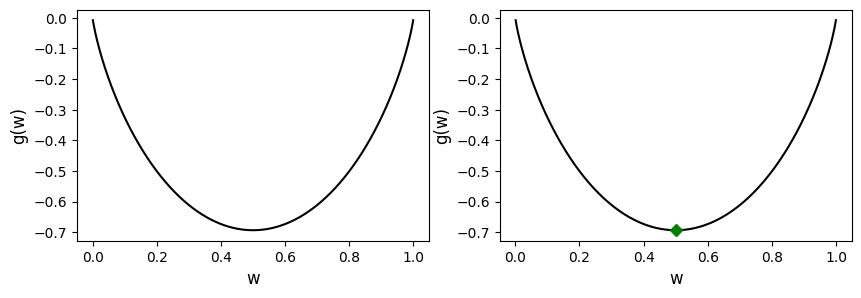

In [125]:
def objective(w):
	return w*np.log(w) + (1-w)*np.log(1-w)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
r_min, r_max = 0., 1.
inputs = np.arange(r_min, r_max, 0.001)
results = objective(inputs)
peaks_max, _ = find_peaks(results)
peaks_min, _ = find_peaks(-results)
ax1.plot(inputs, results, 'k')
ax1.set_xlabel('w', fontsize=12)
ax1.set_ylabel('g(w)', fontsize=12)
ax2.plot(inputs, results, 'k')
ax2.set_xlabel('w', fontsize=12)
ax2.set_ylabel('g(w)', fontsize=12)
ax2.plot(inputs[peaks_max], results[peaks_max], "gD")
ax2.plot(inputs[peaks_min], results[peaks_min], "gD")
plt.show()


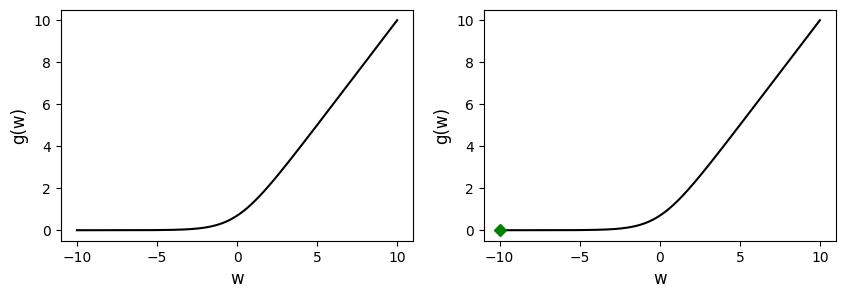

In [126]:
def objective(w):
	return np.log(1+np.exp(w))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
r_min, r_max = -10.0, 10.0
inputs = np.arange(r_min, r_max, 0.001)
results = objective(inputs)
peaks_max, _ = find_peaks(results)
peaks_min, _ = find_peaks(-results)
ax1.plot(inputs, results, 'k')
ax1.set_xlabel('w', fontsize=12)
ax1.set_ylabel('g(w)', fontsize=12)
ax2.plot(inputs, results, 'k')
ax2.set_xlabel('w', fontsize=12)
ax2.set_ylabel('g(w)', fontsize=12)
ax2.plot(inputs[0], np.min(results), "gD")
plt.show()

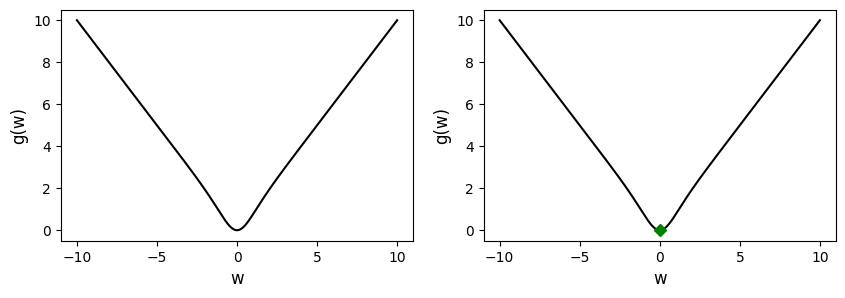

In [127]:
def objective(w):
    return w*np.tanh(w)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
r_min, r_max = -10.0, 10.0
inputs = np.arange(r_min, r_max, 0.001)
results = objective(inputs)
peaks_max, _ = find_peaks(results)
peaks_min, _ = find_peaks(-results)
ax1.plot(inputs, results, 'k')
ax1.set_xlabel('w', fontsize=12)
ax1.set_ylabel('g(w)', fontsize=12)
ax2.plot(inputs, results, 'k')
ax2.set_xlabel('w', fontsize=12)
ax2.set_ylabel('g(w)', fontsize=12)
ax2.plot(inputs[peaks_max], results[peaks_max], "gD")
ax2.plot(inputs[peaks_min], results[peaks_min], "gD")
plt.show()


AttributeError: module 'numpy' has no attribute 'rand'

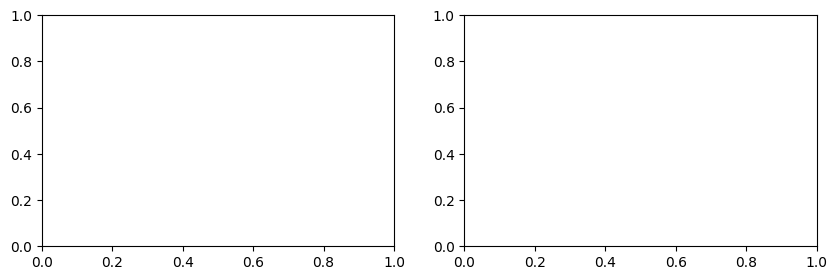

In [128]:
def objective(w, C, b):
    return 0.5*w.T*C*w + b.T@w

C = np.array([[2,1],[1,3]])
b = np.array([1,1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
r_min, r_max = -10.0, 10.0
# inputs = np.arange(r_min, r_max, 0.001)
inputs = np.rand
results = objective(inputs, C, b)
peaks_max, _ = find_peaks(results)
peaks_min, _ = find_peaks(-results)
ax1.plot(inputs, results, 'k')
ax1.set_xlabel('w', fontsize=12)
ax1.set_ylabel('g(w)', fontsize=12)
ax2.plot(inputs, results, 'k')
ax2.set_xlabel('w', fontsize=12)
ax2.set_ylabel('g(w)', fontsize=12)
ax2.plot(inputs[peaks_max], results[peaks_max], "gD")
ax2.plot(inputs[peaks_min], results[peaks_min], "gD")
plt.show()


### Q3.5) Gradient Descent

In [129]:
## This code cell will not be shown in the HTML version of this notebook
# using an automatic differentiator - like the one imported via the statement below - makes coding up gradient descent a breeze
from autograd import numpy as np
from autograd import value_and_grad 

# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha_choice,max_its,w):
    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(w)
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(w)
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g(w))  
    return weight_history,cost_history

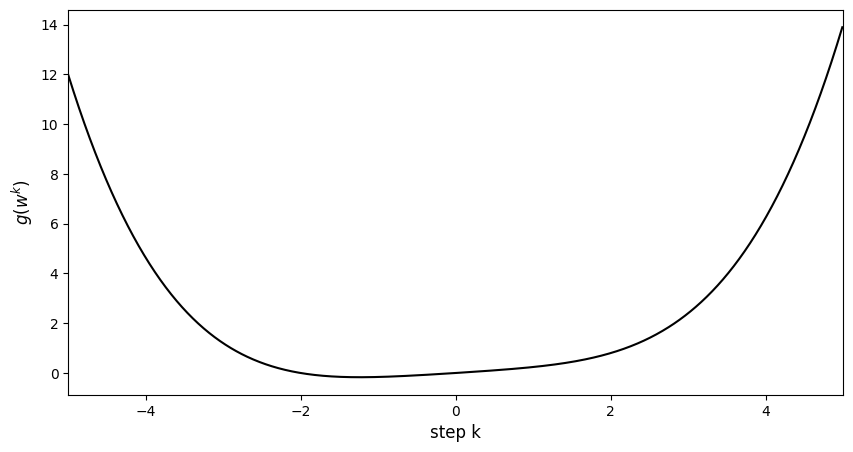

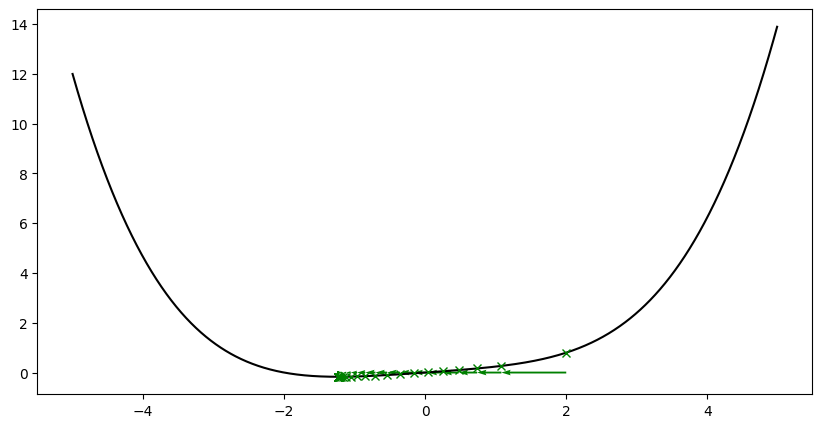

In [130]:
def g(w):
    return 0.02 * (w**4 + w**2 + 10*w)

# run gradient descent
alpha = 1.; w = 2.; max_its = 1000;
weight_history_1,cost_history_1 = gradient_descent(g,alpha,max_its,w)
weights_steps_x_1 = np.array(weight_history_1)

r_min = -5; r_max = 5
plt.figure(figsize=(10,5))
x = np.arange(r_min,r_max,0.01)
plt.plot(x, g(x), 'k-')
plt.xlabel('step k', fontsize=12)
plt.ylabel(r'$g(w^k)$', fontsize=12)
plt.xlim(-5,5)
plt.figure(figsize=(10,5))
plt.plot(x, g(x), 'k-')
plt.plot(weight_history_1, cost_history_1, 'gx')
plt.quiver(weights_steps_x_1[:-1], np.zeros(weights_steps_x_1[:-1].shape[0]), weights_steps_x_1[1:]-weights_steps_x_1[:-1], \
    np.zeros(weights_steps_x_1[1:].shape[0]), scale_units='xy', angles='xy', scale=1, color='g')

plt.show()

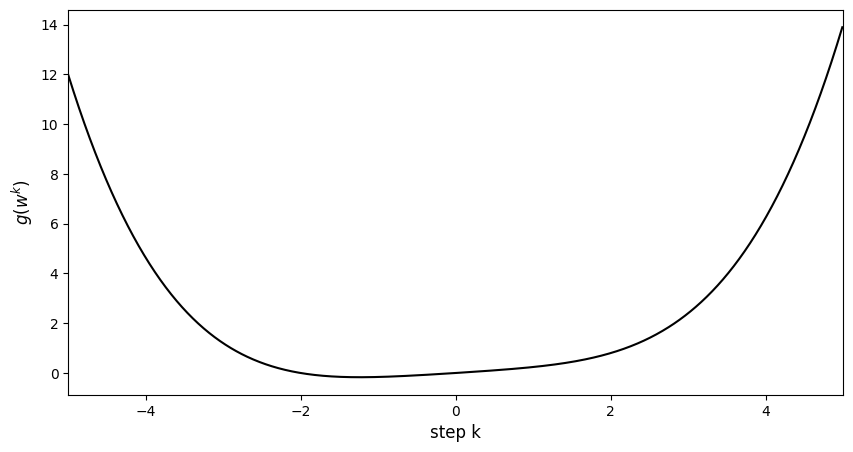

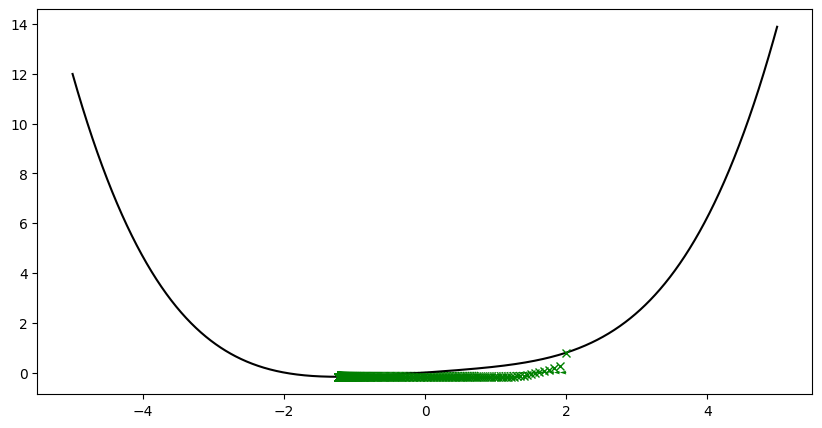

In [131]:
alpha = 0.1; w = 2.; max_its = 1000;
weight_history_1,cost_history_2 = gradient_descent(g,alpha,max_its,w)
weights_steps_x_1 = np.array(weight_history_1)

r_min = -5; r_max = 5
plt.figure(figsize=(10,5))
x = np.arange(r_min,r_max,0.01)
plt.plot(x, g(x), 'k-')
plt.xlabel('step k', fontsize=12)
plt.ylabel(r'$g(w^k)$', fontsize=12)
plt.xlim(-5,5)
plt.figure(figsize=(10,5))
plt.plot(x, g(x), 'k-')
plt.plot(weight_history_1, cost_history_1, 'gx')
plt.quiver(weights_steps_x_1[:-1], np.zeros(weights_steps_x_1[:-1].shape[0]), weights_steps_x_1[1:]-weights_steps_x_1[:-1], \
    np.zeros(weights_steps_x_1[1:].shape[0]), scale_units='xy', angles='xy', scale=1, color='g')

plt.show()





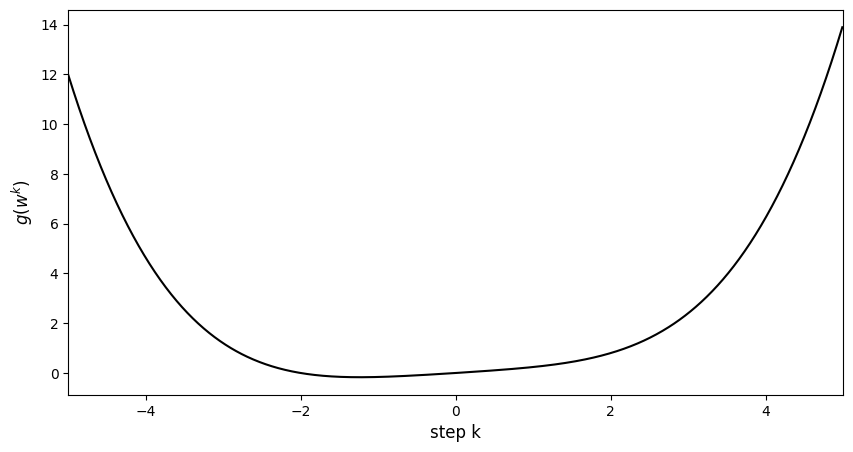

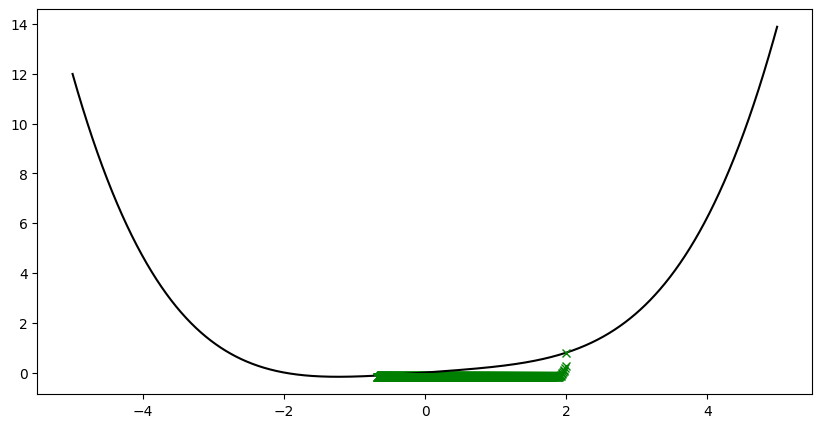

In [132]:
alpha = 0.01; w = 2.; max_its = 1000;
weight_history_1,cost_history_3 = gradient_descent(g,alpha,max_its,w)
weights_steps_x_1 = np.array(weight_history_1)

r_min = -5; r_max = 5
plt.figure(figsize=(10,5))
x = np.arange(r_min,r_max,0.01)
plt.plot(x, g(x), 'k-')
plt.xlabel('step k', fontsize=12)
plt.ylabel(r'$g(w^k)$', fontsize=12)
plt.xlim(-5,5)
plt.figure(figsize=(10,5))
plt.plot(x, g(x), 'k-')
plt.plot(weight_history_1, cost_history_1, 'gx')
plt.quiver(weights_steps_x_1[:-1], np.zeros(weights_steps_x_1[:-1].shape[0]), weights_steps_x_1[1:]-weights_steps_x_1[:-1], \
    np.zeros(weights_steps_x_1[1:].shape[0]), scale_units='xy', angles='xy', scale=1, color='g')

plt.show()

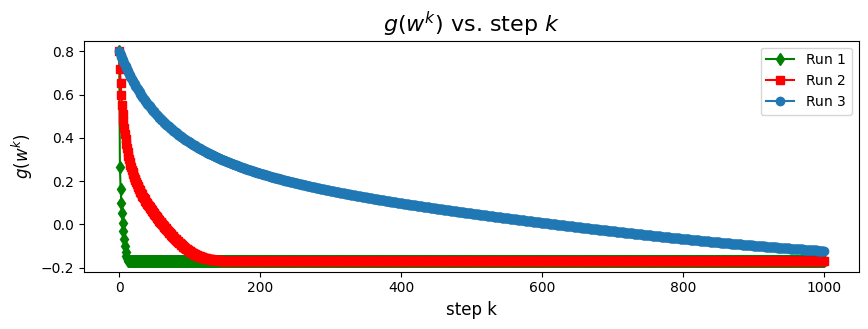

In [133]:
plt.figure(figsize=(10,3))
plt.plot(range(0,max_its+1), cost_history_1, 'dg-', label = r'Run $1$')
plt.plot(range(0,max_its+1), cost_history_2, 'sr-',  label = r'Run $2$')
plt.plot(range(0,max_its+1), cost_history_3, 'o-',  label = r'Run $3$')
plt.title(r'$g(w^k)$ vs. step $k$', fontsize=16)
plt.xlabel('step k', fontsize=12)
plt.ylabel(r'$g(w^k)$', fontsize=12)
plt.legend()
plt.show()

In [136]:

g = lambda w: np.dot(w.T,w)[0][0]

N = 10
alpha = 10**(0); max_its = 100; w = 10*np.ones((N,1))
weight_history_1,cost_history_1 = gradient_descent(g,alpha,max_its,w)

alpha = 10**(-1)
weight_history_2,cost_history_2 = gradient_descent(g,alpha,max_its,w)

alpha = 10**(-2)
weight_history_3,cost_history_3 = gradient_descent(g,alpha,max_its,w)


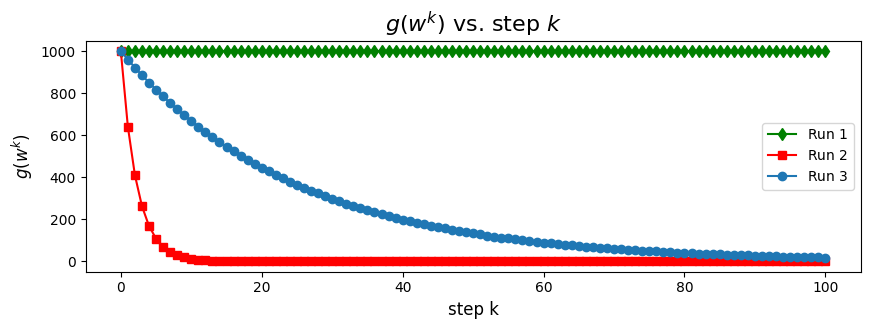

In [137]:
plt.figure(figsize=(10,3))
plt.plot(range(0,max_its+1), cost_history_1, 'dg-', label = r'Run $1$')
plt.plot(range(0,max_its+1), cost_history_2, 'sr-',  label = r'Run $2$')
plt.plot(range(0,max_its+1), cost_history_3, 'o-',  label = r'Run $3$')
plt.title(r'$g(w^k)$ vs. step $k$', fontsize=16)
plt.xlabel('step k', fontsize=12)
plt.ylabel(r'$g(w^k)$', fontsize=12)
plt.legend()
plt.show()